Epoch 1/20
3/3 [==============================] - 1s 1ms/step - loss: 0.2737
Epoch 2/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2694
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2652
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2609
Epoch 5/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2566
Epoch 6/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2522
Epoch 7/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2477
Epoch 8/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2431
Epoch 9/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2383
Epoch 10/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2332
Epoch 11/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2280
Epoch 12/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2225
Epoch 13/20
3/3 [==============================] - 0s 1ms/step - loss: 0.

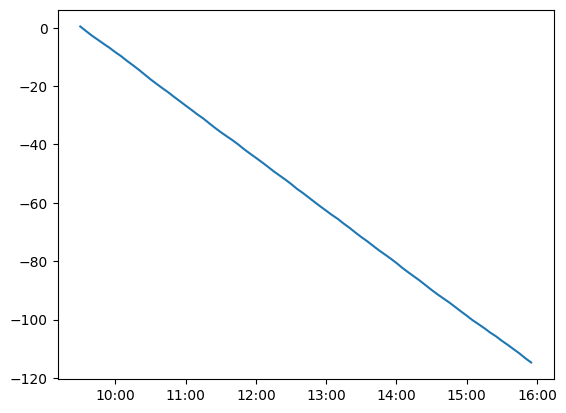

1/1 [==============================] - 0s 102ms/step
09:35:00:0


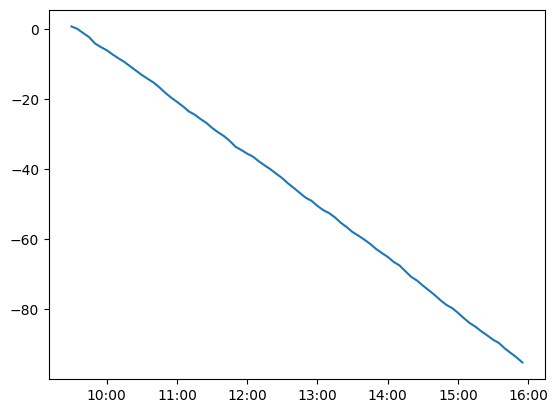

1/1 [==============================] - 0s 100ms/step
09:40:00:0


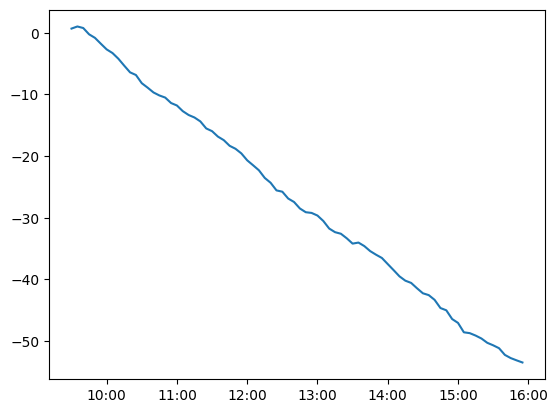

1/1 [==============================] - 0s 98ms/step
09:45:00:0


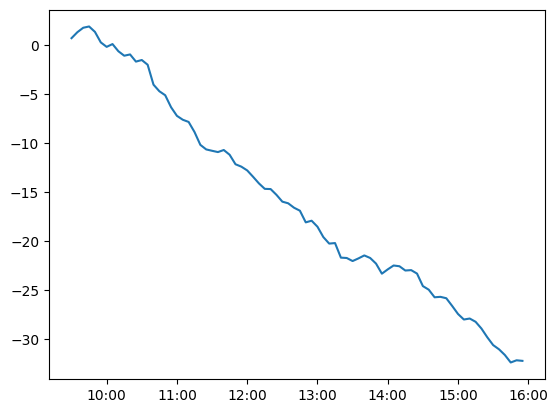

1/1 [==============================] - 0s 99ms/step
GOLONG
09:50:00:0.7799999999999727


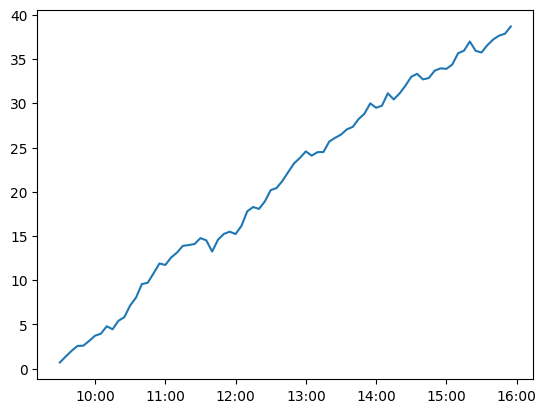

1/1 [==============================] - 0s 102ms/step
09:55:00:0.7799999999999727


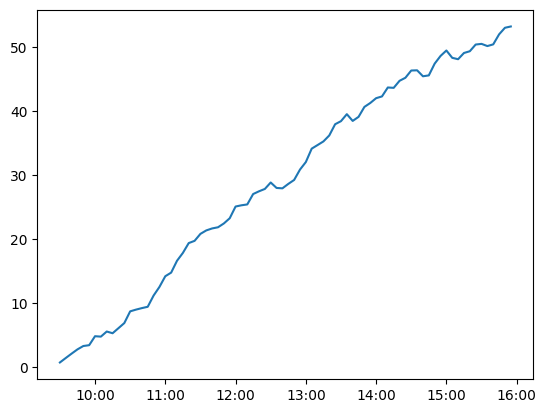

1/1 [==============================] - 0s 99ms/step
10:00:00:0.7799999999999727


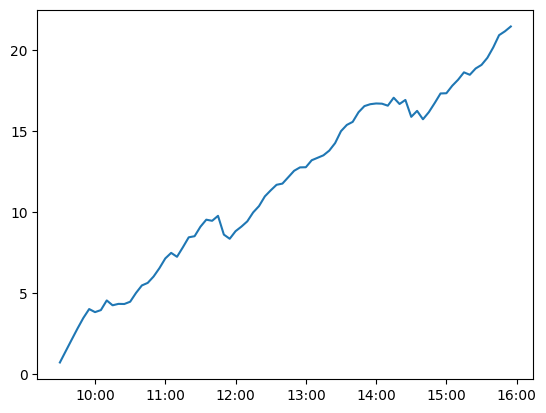

1/1 [==============================] - 0s 99ms/step
GOSHORT
10:05:00:0.9099999999999682


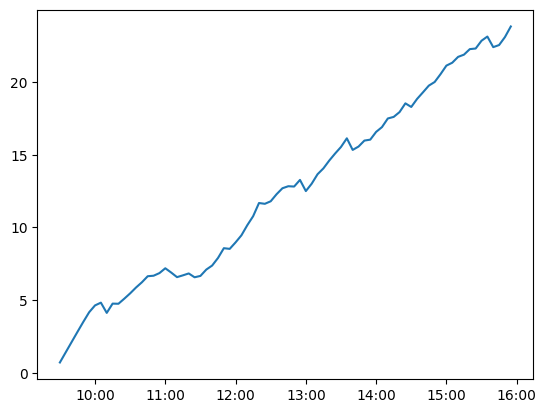

1/1 [==============================] - 0s 100ms/step
GOLONG
10:10:00:0.9999999999999432


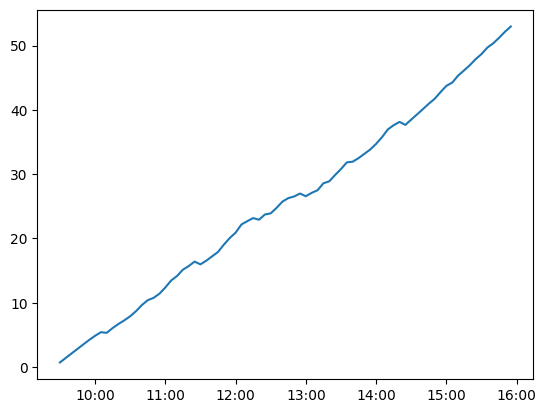

1/1 [==============================] - 0s 98ms/step
10:15:00:0.9999999999999432


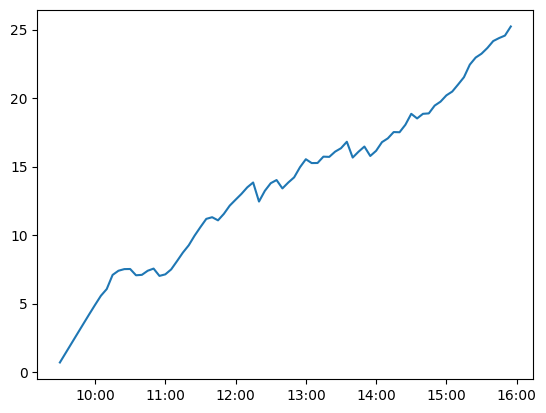

1/1 [==============================] - 0s 101ms/step
10:20:00:0.9999999999999432


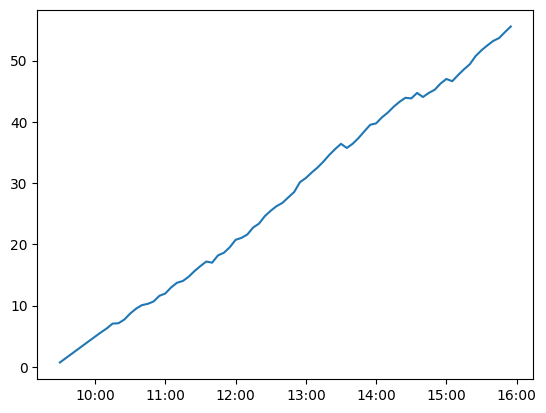

1/1 [==============================] - 0s 98ms/step
10:25:00:0.9999999999999432


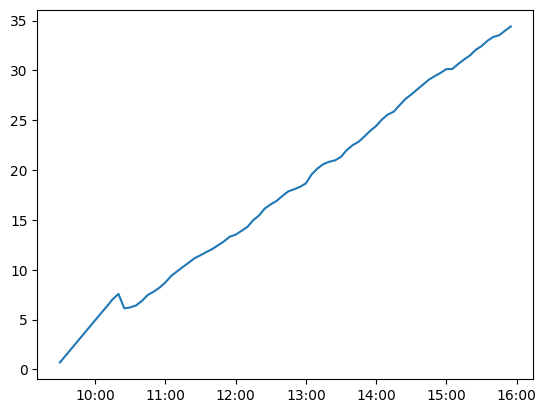

1/1 [==============================] - 0s 99ms/step
10:30:00:0.9999999999999432


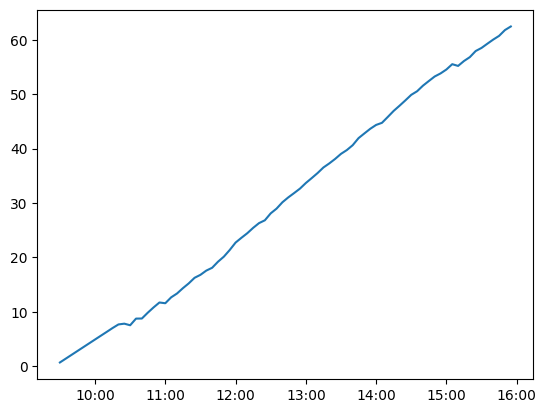

1/1 [==============================] - 0s 98ms/step
10:35:00:0.9999999999999432


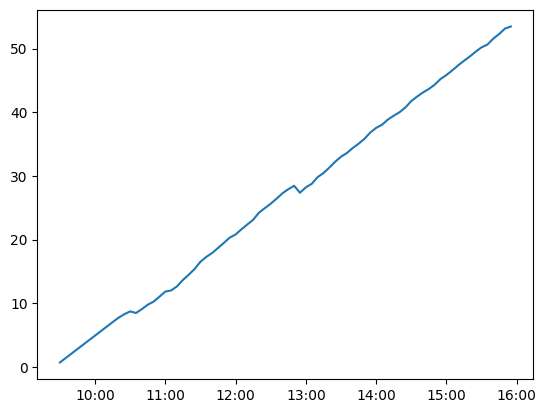

1/1 [==============================] - 0s 100ms/step
10:40:00:0.9999999999999432


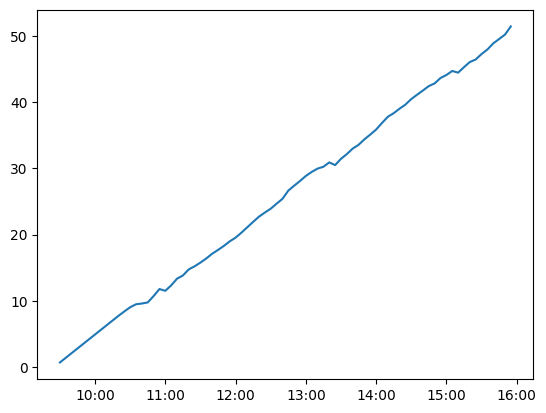

1/1 [==============================] - 0s 102ms/step
10:45:00:0.9999999999999432


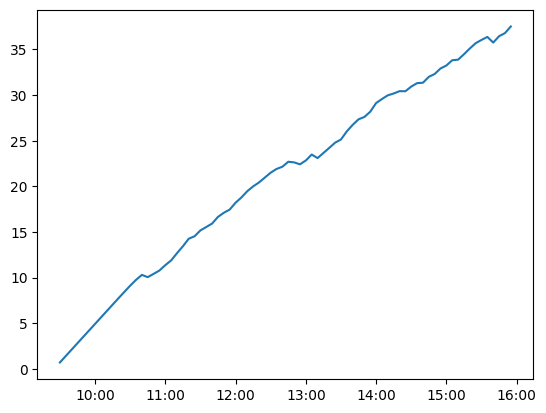

1/1 [==============================] - 0s 98ms/step
10:50:00:0.9999999999999432


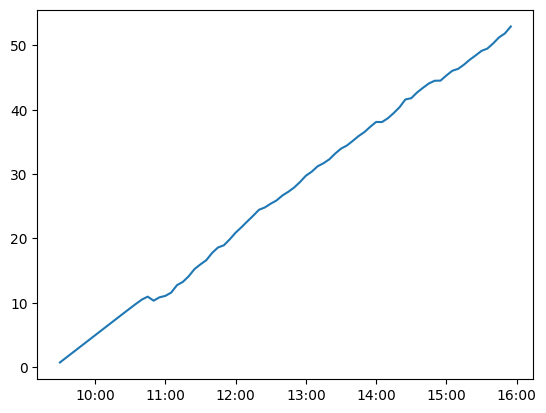

1/1 [==============================] - 0s 98ms/step
10:55:00:0.9999999999999432


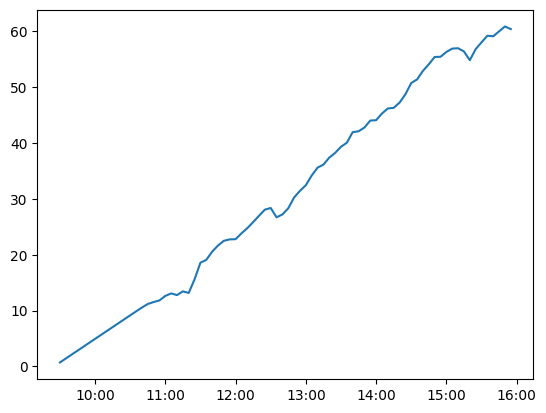

1/1 [==============================] - 0s 100ms/step
11:00:00:0.9999999999999432


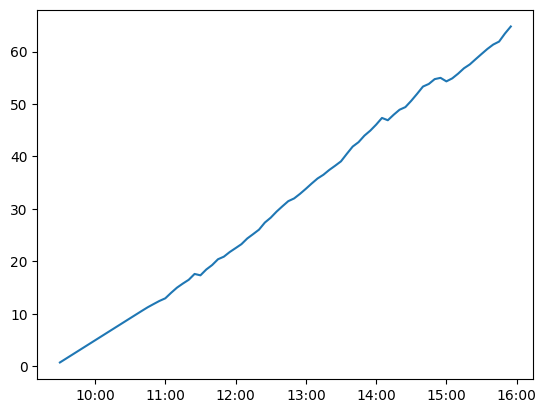

1/1 [==============================] - 0s 104ms/step
11:05:00:0.9999999999999432


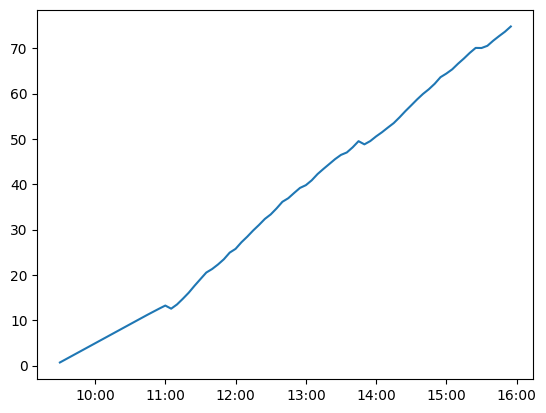

1/1 [==============================] - 0s 101ms/step
11:10:00:0.9999999999999432


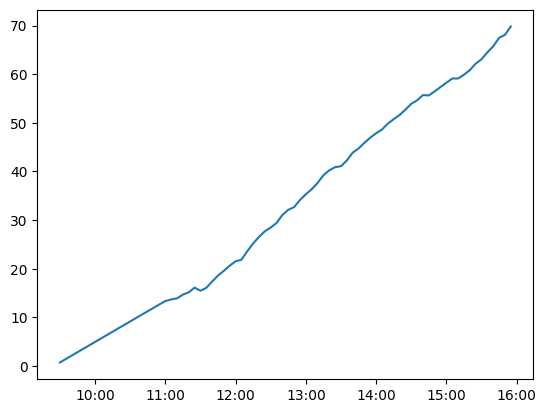

KeyboardInterrupt: 

In [12]:
from modelClasses import BasicModel
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from time import sleep
from datetime import datetime, date, timedelta, time
import threading
from decimal import *

df = pd.read_csv('C:\\src\\stockPredictor\\SpyHist.csv', index_col=0)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = [d.date() for d in df['DateTime']]
df['time'] = [d.time() for d in df['DateTime']]
df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['slowsma'] = df['Close'].rolling(21).mean()
df['fastsma'] = df['Close'].rolling(9).mean()
df['Difference'] = df['Close'] - df['Open']
df = df.dropna()

for currentDate in df.date.unique():
    if len(df.date.unique()) > len(df.loc[df['date'] == currentDate]):
        df = df.loc[df['date'] != currentDate]

new_day_data = df.loc[df['date'] == (datetime.today() - timedelta(days=1)).date()]

df = df.loc[df['date'] != (datetime.today() - timedelta(days=1)).date()]

currentModel = BasicModel(df)
new_day_data[currentModel.inputs] = currentModel.inputScalar.transform(new_day_data[currentModel.inputs])

currentModel.build()

lastPrice = 0
totalWin = 0

long = False
short = False

for i in range(1,len(new_day_data)-1): 
    todaysData = pd.DataFrame(new_day_data[:i])

    currentTick = todaysData.iloc[-1]
    todaysData = todaysData.loc[todaysData['time'].isin(todaysData.time.unique())]
    loadedModel = tf.keras.models.load_model('model_'+str(todaysData.iloc[-1]['time']).replace(':','_')+'.keras')
                
    X = np.array(todaysData[currentModel.inputs])
    input_sequence = X.reshape(1, len(todaysData), currentModel.numInput)
    predicted_sequence = currentModel.outputScalar.inverse_transform(pd.DataFrame(loadedModel.predict(input_sequence)[0], columns=['Difference']))

    todaysData[['Difference']] = currentModel.outputScalar.inverse_transform(todaysData[['Difference']])
    
    dfTotal = pd.DataFrame(columns=['Total','Time'])
    total = 0
    highest = 0
    crossoverHighest = 0
    positive = predicted_sequence[0] > 0
    
    for i in range(0,len(predicted_sequence)):
        total = total + predicted_sequence[i]
        if positive:
            if total < 0:
                crossoverHighest = total
                for j in range(i+1,len(predicted_sequence)):
                    total = total + predicted_sequence[j]
                    if total > 0:
                        break
                    if crossoverHighest > total:
                        crossoverHighest = total
                break
            if highest < total:
                highest = total
        else:
            if total > 0:
                crossoverHighest = total
                for j in range(i+1,len(predicted_sequence)):
                    total = total + predicted_sequence[j]
                    if total < 0:
                        break
                    if crossoverHighest < total:
                        crossoverHighest = total
                break
            if highest > total:
                highest = total
    
    highest = abs(highest)
    crossoverHighest = abs(crossoverHighest)
    percentChange = highest / todaysData.iloc[-1]['Close'] * 100
    crossoverPercentChange = crossoverHighest / todaysData.iloc[-1]['Close'] * 100

    if long == False and short == False:
        if positive and percentChange > 0.05:
            print('GOLONG')
            lastPrice = todaysData.iloc[-1]['Close']
            long = True
        if not positive and percentChange > 0.05:
            print('GOSHORT')
            lastPrice = todaysData.iloc[-1]['Close']
            short = True
    if long == True:
        if not positive and percentChange > 0.05:
            print('GOSHORT')
            totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
            lastPrice = todaysData.iloc[-1]['Close']
            long = False
            short = True
        elif not positive and crossoverPercentChange > percentChange:
            print('SELL')
            totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
            lastPrice = todaysData.iloc[-1]['Close']
            long = False
    if short == True:
        if positive and percentChange > 0.05:
            print('GOLONG')
            totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
            lastPrice = todaysData.iloc[-1]['Close']
            short = False
            long = True
        elif positive and crossoverPercentChange > percentChange:
            print('BUY')
            totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
            lastPrice = todaysData.iloc[-1]['Close']
            short = False

    print(str(todaysData.iloc[-1]['time']) + ':' + str(totalWin))

    dfTotal = pd.DataFrame(columns=['Total','Time'])
    Total = 0
    count = 0
    for currentTime in df.time.unique():
        if(todaysData.loc[todaysData['time']==currentTime].empty is False):
            Total = Total + todaysData.loc[todaysData['time']==currentTime]['Difference'].values[0]
        else:
            Total = Total + predicted_sequence[count]
            count = count + 1
        dfTotal.loc[len(dfTotal.index)] = [Total,currentTime] 
    datetimes = [datetime.combine(date.today(), t) for t in dfTotal["Time"]]
    xformatter = mdates.DateFormatter('%H:%M')
    plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.show()

    timeToWait = 1
    if timeToWait > 0:
        sleep(timeToWait)

totalWin =  totalWin + abs(lastPrice  - todaysData.iloc[-1]['Close'])
print(totalWin)

In [13]:
new_day_data

,DateTime,Open,Close,Volume,date,time,Difference,slowsma,fastsma
6552,2023-10-18 09:30:00-04:00,434.19,434.65,1216781,2023-10-18,09:30:00,0.703571,435.171905,435.295556
6553,2023-10-18 09:35:00-04:00,434.64,433.97,815558,2023-10-18,09:35:00,0.703571,435.116190,435.158889
6554,2023-10-18 09:40:00-04:00,433.96,433.71,941728,2023-10-18,09:40:00,0.703571,435.047619,434.962222
6555,2023-10-18 09:45:00-04:00,433.71,433.84,947024,2023-10-18,09:45:00,0.703571,434.985714,434.820000
6556,2023-10-18 09:50:00-04:00,433.84,433.87,824592,2023-10-18,09:50:00,0.703571,434.909048,434.678889
...,...,...,...,...,...,...,...,...,...
6625,2023-10-18 15:35:00-04:00,430.71,430.42,994145,2023-10-18,15:35:00,-0.290000,431.445238,430.704444
6626,2023-10-18 15:40:00-04:00,430.41,429.97,1882921,2023-10-18,15:40:00,-0.440000,431.325238,430.566667
6627,2023-10-18 15:45:00-04:00,429.97,429.45,3300791,2023-10-18,15:45:00,-0.520000,431.181429,430.421111
6628,2023-10-18 15:50:00-04:00,429.45,430.07,3284883,2023-10-18,15:50:00,0.620000,431.047143,430.377778
